In [1]:
from __future__ import print_function, division
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import congress_tools as cong

%matplotlib inline

In [2]:
colors = {}
colors['gray'] = 'gray'
colors['blue'] = '#3498db'
colors['red'] = '#e74c3c'

fonts = {}
fonts['xlabelsize'] = 18
fonts['ylabelsize'] = 16
fonts['titlesize'] = 20

fonts['xlabelweight'] = 'bold'
fonts['ylabelweight'] = 'bold'
fonts['titleweight'] = 'bold'

figset = {}
figset['dpi'] = 300
figset['alpha'] = 0.7

In [3]:
year = 2014

# reapportion seats to expected values
methodReapportion = 'state'

# this file was saved by preprocess.ipynb
filename = '../data/df_stateSummary_%d_%sReapportion.pkl' % (year, methodReapportion)
data = pd.read_pickle(filename)

# Summary: State-level reapportionment

In [4]:
print('Expected seats %d:\nDemocratic: %d\nRepublican: %d' % (year,data.nDemDistExpect.sum(), data.nRepDistExpect.sum()))

Expected seats 2014:
Democratic: 201
Republican: 234


# Analysis: Compactness and Redistricting Control

## Get average compactness for states with different redistricting control

In [5]:
data['avg_compact'] = data.compact.apply(np.mean)
treatment_oneParty_avgCompact = data[data['redist_ctrl'].isin(['D','R'])]['avg_compact']
treatment_split_avgCompact = data[data['redist_ctrl'].isin(['Split','Nonpartisan'])]['avg_compact']

In [6]:
# data is not normally distributed, need to transform
print("Before transformation")
print(stats.normaltest(treatment_oneParty_avgCompact))
print(stats.normaltest(treatment_split_avgCompact))
print("After log transformation")
print(stats.normaltest(treatment_oneParty_avgCompact.apply(np.log)))
print(stats.normaltest(treatment_split_avgCompact.apply(np.log)))

Before transformation
(6.5698815209004442, 0.037442803122508549)
(13.337726037258497, 0.00126984171691505)
After log transformation
(0.45101913497692925, 0.79810942450865019)
(3.1012070938129308, 0.21211991086862494)


/Users/matt/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  int(n))


In [7]:
# t-test 
stats.ttest_ind(treatment_oneParty_avgCompact.apply(np.log), 
                treatment_split_avgCompact.apply(np.log), equal_var=False)

(-3.1420995538277077, 0.0031574071144885906)

## Average district compactness in states with single-party control of redistricting are significantly less compact than those from states with split or nonpartisan controlm

In [8]:
print('Compactness:')
print('Single-party redistricting control: %.4f' % treatment_oneParty_avgCompact.mean())
print('Split-party redistricting control: %.4f' % treatment_split_avgCompact.mean())

Compactness:
Single-party redistricting control: 0.2210
Split-party redistricting control: 0.2838


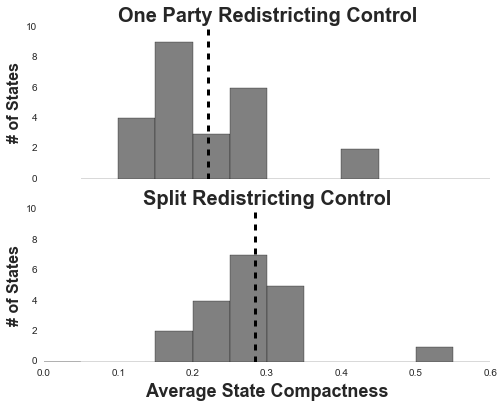

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8,6))

bins = 12
binrange = (0, 0.6)

ylim = (0, 10)
xlim = (0, 0.6)

ax1.hist(list(treatment_oneParty_avgCompact), bins=bins, color=colors['gray'], range=binrange)
ax2.hist(list(treatment_split_avgCompact), bins=bins, color=colors['gray'], range=binrange)

# clean up plot
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid(False)
ax2.grid(False)

ax1.set_ylabel("# of States", fontsize=fonts['ylabelsize'], fontweight=fonts['ylabelweight'])
ax2.set_ylabel("# of States", fontsize=fonts['ylabelsize'], fontweight=fonts['ylabelweight'])

ax2.set_xlabel("Average State Compactness", fontsize=fonts['xlabelsize'], fontweight=fonts['xlabelweight'])

ax1.set_title('One Party Redistricting Control', fontsize=fonts['titlesize'], fontweight=fonts['titleweight'])
ax2.set_title('Split Redistricting Control', fontsize=fonts['titlesize'], fontweight=fonts['titleweight'])

# vertical lines at mean
ax1.axvline(treatment_oneParty_avgCompact.mean(), color='black', linestyle='dashed', linewidth=3)
ax2.axvline(treatment_split_avgCompact.mean(), color='black', linestyle='dashed', linewidth=3)

plt.savefig("compact_redistControl.png", bbox_inches='tight', dpi=figset['dpi'])

# Analysis: Compactness and Gerrymandering Score

In [10]:
methodReapportion = 'state'

year = 2012
# year = 2014

# load district data, this file was saved by preprocess.ipynb
filename = '../data/df_distSummary_%d_%sReapportion.pkl' % (year, methodReapportion)
dfdist = pd.read_pickle(filename)

## Calculate a gerrymandering score using the number of packed and cracked districts and other criteria

In [11]:
# minimum number of districts a state needs to be included
minDist = 4

# the limits on vote proportion that one party needs in a given district to be packed
packMin = 75
packMax = 99

# the limits on vote proportion that one party needs to be cracked
crackMin = 35
crackMax = 49

scoreLim = 2
delta_R_lim = 1

printDebug = False

dfdist, state_gerry = cong.gerry_score(dfdist,minDist=minDist,
                                       packMin=packMin,packMax=packMax,
                                       crackMin=crackMin,crackMax=crackMax,
                                       scoreLim=scoreLim,delta_R_lim=delta_R_lim,printDebug=printDebug)

seat difference: 26 (positive indicates number of R seats that should be D)
[u'MI', u'AL', u'TX', u'SC', u'PA', u'OH', u'VA', u'NC', u'IN', u'FL']


In [12]:
# Separate districts from gerrymandered and non-gerrymandered states
dfdist_gm = dfdist[dfdist['state'].isin(state_gerry)]
dfdist_nogm = dfdist[~dfdist['state'].isin(state_gerry)]

In [13]:
# data is not normally distributed, need to transform
print("Before transformation")
print(stats.normaltest(dfdist_gm['compact']))
print(stats.normaltest(dfdist_nogm['compact']))
print("After sqrt transformation")
print(stats.normaltest(dfdist_gm['compact']**.5))
print(stats.normaltest(dfdist_nogm['compact']**.5))

Before transformation
(15.549719198286761, 0.00042016645694516153)
(20.627299788595963, 3.3177126036509291e-05)
After sqrt transformation
(4.6019953640994702, 0.10015886715480074)
(0.3160547909537525, 0.85382639066693344)


In [14]:
# t-test
stats.ttest_ind(dfdist_gm['compact']**.5, dfdist_nogm['compact']**.5, equal_var=False)

(-3.1673863017585977, 0.0017017155350526607)

## Districts from gerrymandered states are significantly less compact than those from non-gerrymandered states

In [15]:
print('Compactness by Gerrymandering')
print('Gerrymandered: %.4f' % dfdist_gm['compact'].mean())
print('Non-gerrymandered: %.4f' % dfdist_nogm['compact'].mean())

Compactness by Gerrymandering
Gerrymandered: 0.2205
Non-gerrymandered: 0.2537


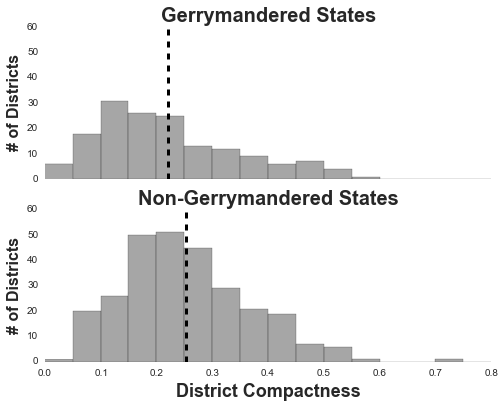

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')

ylim = (0, 60)
xlim = (0, 0.8)

bins = 16
binrange = (0, 0.8)

dfdist_gm['compact'].hist(ax=ax1, alpha=figset['alpha'], color='gray', bins=bins, range=binrange)
dfdist_nogm['compact'].hist(ax=ax2, alpha=figset['alpha'], color='gray', bins=bins, range=binrange)
# vertical mean lines
ax1.axvline(dfdist_gm['compact'].mean(), color='black', linestyle='dashed', linewidth=3)
ax2.axvline(dfdist_nogm['compact'].mean(), color='black', linestyle='dashed', linewidth=3)

# clean up plot
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid(False)
ax2.grid(False)

ax1.set_ylabel('# of Districts', fontsize=fonts['ylabelsize'], fontweight=fonts['ylabelweight'])
ax2.set_ylabel('# of Districts', fontsize=fonts['ylabelsize'], fontweight=fonts['ylabelweight'])

ax2.set_xlabel('District Compactness', fontsize=fonts['xlabelsize'], fontweight=fonts['xlabelweight'])

ax1.set_title('Gerrymandered States', fontsize=fonts['titlesize'], fontweight=fonts['titleweight'])
ax2.set_title('Non-Gerrymandered States', fontsize=fonts['titlesize'], fontweight=fonts['titleweight'])

plt.savefig("gm_compact_%d.png" % (year), bbox_inches='tight', dpi=figset['dpi'])

# Analysis: Compactness and District PVI

In [17]:
methodReapportion = 'state'
# methodReapportion = 'country'

year = 2012
# year = 2014

# load district data, this file was saved by preprocess.ipynb
filename = '../data/df_distSummary_%d_%sReapportion.pkl' % (year, methodReapportion)
dfdist = pd.read_pickle(filename)

In [18]:
# convert PVI to integer
dfdist['pvi_dist'] = dfdist['pvi_dist'].astype(np.int)

In [19]:
# the states below have only one congressional district
oneCD = ['AK', 'DE', 'MT', 'ND', 'SD', 'VT', 'WY']
# create data frame without these states
df_noAtLarge = dfdist[~dfdist.state.isin(oneCD)]

In [20]:
# split data by PVI
demS = df_noAtLarge[df_noAtLarge['pvi_dist'] > 5]
repS = df_noAtLarge[(df_noAtLarge['pvi_dist'] < -5)]
swS = df_noAtLarge[(df_noAtLarge['pvi_dist'] <=5) & (df_noAtLarge['pvi_dist'] >= - 5)]

In [21]:
# data is not normally distributed, need to transform
print("Before transformation")
print(stats.normaltest(demS['compact']))
print(stats.normaltest(repS['compact']))
print(stats.normaltest(swS['compact']))
print("After sqrt transformation")
print(stats.normaltest(demS['compact']**0.5))
print(stats.normaltest(repS['compact']**0.5))
print(stats.normaltest(swS['compact']**0.5))

Before transformation
(15.768551362299874, 0.00037661930523347274)
(14.889970113859503, 0.00058436483254290135)
(10.638993446575057, 0.0048952167539897638)
After sqrt transformation
(1.103187636764509, 0.57603098957830978)
(5.4867572793241468, 0.064352555085359517)
(4.4849158592101359, 0.10619715818647513)


## There is a difference in compactness between the three groups

In [22]:
f_val, p_val = stats.f_oneway(demS['compact']**0.5, swS['compact']**0.5, repS['compact']**0.5) 
print([f_val, p_val])

[9.142062238425174, 0.00012962381814904329]


## All three groups are different from each other

In [23]:
print(stats.ttest_ind(repS['compact']**0.5,swS['compact']**0.5, equal_var=False))
print(stats.ttest_ind(demS['compact']**0.5,swS['compact']**0.5,equal_var=False))
print(stats.ttest_ind(demS['compact']**0.5,repS['compact']**0.5,equal_var=False))

(-2.3430012418310611, 0.020152981677101986)
(-4.0422038547529793, 7.2152486190037811e-05)
(-2.3424164958765012, 0.019862974682074899)


In [24]:
# false discovery rate correction for multiple comparisons

# requires nibabel and nipy
import nipy.algorithms.statistics.empirical_pvalue as pv
pv.fdr([0.020152981677101476,7.215*10**(-5), 0.019862974682074624])

array([ 0.02015298,  0.00021645,  0.02015298])

### The average compactness of three groups is not the same. Democratic districts have lower compactness than Republican districts on average. Swing districts have the largest average compactness.

In [25]:
print('Compactness by PVI')
print('Democratic: %.4f' % demS['compact'].mean())
print('Republican: %.4f' % repS['compact'].mean())
print('Swing: %.4f' % swS['compact'].mean())

Compactness by PVI
Democratic: 0.2150
Republican: 0.2379
Swing: 0.2736


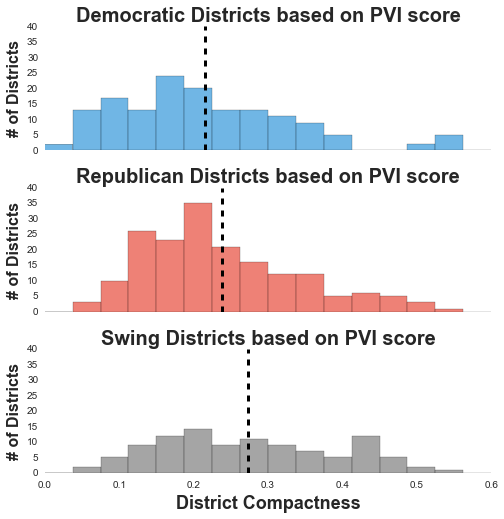

In [26]:
f, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8, 8))
f.subplots_adjust(wspace=0.08,hspace=0.3)
# f.set_size_inches(10,10)

ylim = (0, 40)
xlim = (0, 0.6)

bins = 16
binrange = (0, 0.6)

# plot histograms
demS['compact'].hist(ax=ax1, color=colors['blue'], alpha=figset['alpha'], bins=bins, range=binrange)
repS['compact'].hist(ax=ax2, color=colors['red'], alpha=figset['alpha'], bins=bins, range=binrange)
swS['compact'].hist(ax=ax3, color = colors['gray'], alpha=figset['alpha'], bins=bins, range=binrange)

# set labels
ax1.set_title('Democratic Districts based on PVI score', fontsize=fonts['titlesize'], fontweight=fonts['titleweight'])
ax2.set_title('Republican Districts based on PVI score', fontsize=fonts['titlesize'], fontweight=fonts['titleweight'])
ax3.set_title('Swing Districts based on PVI score', fontsize=fonts['titlesize'], fontweight=fonts['titleweight'])

ax3.set_xlabel('District Compactness', fontsize=fonts['xlabelsize'], fontweight=fonts['xlabelweight'])

ax1.set_ylabel('# of Districts', fontsize=fonts['ylabelsize'], fontweight=fonts['ylabelweight'])
ax2.set_ylabel('# of Districts', fontsize=fonts['ylabelsize'], fontweight=fonts['ylabelweight'])
ax3.set_ylabel('# of Districts', fontsize=fonts['ylabelsize'], fontweight=fonts['ylabelweight'])

# vertical mean lines
ax1.axvline(demS['compact'].mean(), color='black', linestyle='dashed', linewidth=3)
ax2.axvline(repS['compact'].mean(), color='black', linestyle='dashed', linewidth=3)
ax3.axvline(swS['compact'].mean(), color='black', linestyle='dashed', linewidth=3)

# clean up plot
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

plt.savefig("pvi_comp_hist.png", bbox_inches='tight', dpi=figset['dpi'])

# DIME/CFscore and Gerrymandering Score

In [27]:
methodReapportion = 'state'

year = 2012

# load district data, this file was saved by DIME_load_save.ipynb
filename = '../data/df_distSummary_DIME_%d_%sReapportion.pkl' % (year, methodReapportion)
try:
    dfjoin = pd.read_pickle(filename)
except IOError as e:
    print("Unable to read processed DIME data (using the notebook DIME_load_save.ipynb).")

cfscore = 'cfscores.dyn'

In [28]:
# separate parties
liberalIdx = (dfjoin[cfscore] < 0)
conservIdx = (dfjoin[cfscore] > 0)

# for cfscore
liberalGM = dfjoin[dfjoin['state'].isin(state_gerry) & liberalIdx]
liberalNoGM = dfjoin[~dfjoin['state'].isin(state_gerry) & liberalIdx]

conservGM = dfjoin[dfjoin['state'].isin(state_gerry) & conservIdx]
conservNoGM = dfjoin[~dfjoin['state'].isin(state_gerry) & conservIdx]

In [29]:
print("Before transformation")
print(stats.normaltest(liberalGM[cfscore].dropna()))
print(stats.normaltest(liberalNoGM[cfscore].dropna()))
print(stats.normaltest(conservGM[cfscore].dropna()))
print(stats.normaltest(conservNoGM[cfscore].dropna()))

print("After Box-Cox transformation")
print(stats.normaltest(stats.boxcox(liberalGM[cfscore].dropna().abs())[0]))
print(stats.normaltest(stats.boxcox(liberalNoGM[cfscore].dropna().abs())[0]))
print(stats.normaltest(stats.boxcox(conservGM[cfscore].dropna().abs())[0]))
print(stats.normaltest(stats.boxcox(conservNoGM[cfscore].dropna().abs())[0]))

Before transformation
(7.6984069784978013, 0.021296692729268429)
(4.6627495408828068, 0.09716207967441802)
(18.273953970088016, 0.00010761215143681059)
(6.3455715761256561, 0.041886747617445409)
After Box-Cox transformation
(0.010634772047826944, 0.99469672624860339)
(5.1930586117243358, 0.074531806944095003)
(0.57767784515101261, 0.74913286407706337)
(2.367429849738977, 0.30613933887579753)


In [30]:
# compare four sub-groups
f_val, p_val = stats.f_oneway(stats.boxcox(liberalGM[cfscore].dropna().abs())[0],
                              stats.boxcox(liberalNoGM[cfscore].dropna().abs())[0],
                              stats.boxcox(conservGM[cfscore].dropna().abs())[0],
                              stats.boxcox(conservNoGM[cfscore].dropna().abs())[0])
print([f_val, p_val])

[19.244893723137437, 9.9907072492967353e-12]


## There is a significant difference between liberalness of gerrymandered vs non-gerrymandered states

In [31]:
# liberal GM vs noGM
stats.ttest_ind(stats.boxcox(liberalGM[cfscore].dropna().abs())[0], stats.boxcox(liberalNoGM[cfscore].dropna().abs())[0], equal_var=False)

(-5.3067209726520401, 1.6275804724405473e-06)

## There is no difference between conservativeness of GM vs non-GM states

In [32]:
# conservative GM vs noGM
stats.ttest_ind(stats.boxcox(conservGM[cfscore].dropna().abs())[0], stats.boxcox(conservNoGM[cfscore].dropna().abs())[0], equal_var=False)

(-0.065834794984177436, 0.94756572803515138)

## Non-gerrymandered states are more liberal than gerrymandered states

In [33]:
print('CFscore by Gerrymandering')
print('Liberal GM: %.4f' % liberalGM[cfscore].dropna().mean())
print('Liberal NoGM: %.4f' % liberalNoGM[cfscore].dropna().mean())
print('Conservative GM: %.4f' % conservGM[cfscore].dropna().mean())
print('Conservative NoGM: %.4f' % conservNoGM[cfscore].dropna().mean())

CFscore by Gerrymandering
Liberal GM: -0.6917
Liberal NoGM: -0.9402
Conservative GM: 0.9077
Conservative NoGM: 0.9149


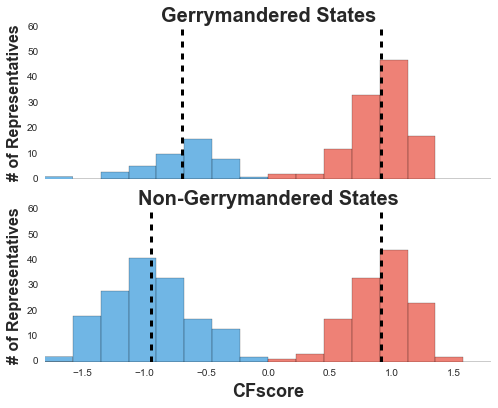

In [34]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')

ylim = (0, 60)
xlim = (-1.8, 1.8)

bins = 16
binrange = (-1.8, 1.8)

# plot separate party cfscore
liberalGM[cfscore].dropna().hist(ax=ax1, alpha=figset['alpha'], color=colors['blue'], bins=bins, range=binrange)
conservGM[cfscore].dropna().hist(ax=ax1, alpha=figset['alpha'], color=colors['red'], bins=bins, range=binrange)
liberalNoGM[cfscore].dropna().hist(ax=ax2, alpha=figset['alpha'], color=colors['blue'], bins=bins, range=binrange)
conservNoGM[cfscore].dropna().hist(ax=ax2, alpha=figset['alpha'], color=colors['red'], bins=bins, range=binrange)

# vertical mean lines
ax1.axvline(liberalGM[cfscore].dropna().mean(), color='black', linestyle='dashed', linewidth=3)
ax1.axvline(conservGM[cfscore].dropna().mean(), color='black', linestyle='dashed', linewidth=3)
ax2.axvline(liberalNoGM[cfscore].dropna().mean(), color='black', linestyle='dashed', linewidth=3)
ax2.axvline(conservNoGM[cfscore].dropna().mean(), color='black', linestyle='dashed', linewidth=3)

# clean up plot
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid(False)
ax2.grid(False)

ax1.set_ylabel('# of Representatives', fontsize=fonts['ylabelsize'], fontweight=fonts['ylabelweight'])
ax2.set_ylabel('# of Representatives', fontsize=fonts['ylabelsize'], fontweight=fonts['ylabelweight'])

ax2.set_xlabel('CFscore', fontsize=fonts['xlabelsize'], fontweight=fonts['xlabelweight'])

ax1.set_title('Gerrymandered States', fontsize=fonts['titlesize'], fontweight=fonts['titleweight'])
ax2.set_title('Non-Gerrymandered States', fontsize=fonts['titlesize'], fontweight=fonts['titleweight'])

plt.savefig("gm_dime_%d.png" % (year), bbox_inches='tight', dpi=figset['dpi'])